In [6]:
import requests
import shutil
import os
from PIL import Image
import PIL.ExifTags
import pandas as pd
import sys
import json
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get cities

user_agent = "Mozilla/5.0"

PROJECT_DATA_DIR = "../../data/projet"
SUB_DATA_DIR = "/import"


def get_exif(img_path: str):
    img = PIL.Image.open(img_path)
    if img._getexif() is None:
        return {}


    return {
        PIL.ExifTags.TAGS[k]: v
        for k, v in img._getexif().items()
        if k in PIL.ExifTags.TAGS
    }


def merge_metadata(row):
    metadata = get_exif(row["local_path"])

    ret = {"have_exif": len(metadata) != 0}

    print(ret)

    if ret["have_exif"]:
        ret["orientation"] = metadata.get("Orientation")

    return ret


def format_import_data_path(image_id):
    return f"{PROJECT_DATA_DIR}{SUB_DATA_DIR}/images/{image_id}.jpg"


def get_results(endpoint_url, query):
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def download_images(row):
    print(type(row))

    def download_image(url, save_path=None):
        headers = {
            "User-Agent": "Mozilla/5.0",
        }

        if not save_path:
            save_path = os.path.basename(url)

        request = requests.get(url, allow_redirects=True, headers=headers, stream=True)

        if request.status_code != 200:
            print(f"Erreur lors du téléchargement des images {request.status_code}")
        else:
            with open(save_path, "wb") as image:
                request.raw.decode_content = True

                shutil.copyfileobj(request.raw, image)
                print("> Image sauvegardé :", save_path)

        return request.status_code

    ret = []

    print("Téléchargement de l'image :", row["local_path"])
    download_image(row["origin_path"], row["local_path"])


def conv(x):
    year, month, day = tuple(x.split("T")[0].split('-'))
    return pd.Period(year=int(year), month=int(month), day=int(day), freq="D")


def format_cities_data(raw_data):
    ret: [] = []
    last_row = {}
    i = 0
    for row in raw_data:
        if row["image"]["value"].endswith("jpg") or row["image"]["value"].endswith("jpeg"):
            try:
                new_row = {
                    "titre": row["peintureLabel"]["value"],
                    "date": conv(row["inceptionLabel"]["value"]),
                    "createur": row["createurLabel"]["value"],
                    "location": row["locationLabel"]["value"],
                    "origin_path": row["image"]["value"]
                }

                is_new = True

                for key in new_row.keys():
                    if new_row[key] == last_row.get(key, ""):
                        is_new = False

                if is_new:
                    ret.append(
                        new_row
                    )
                    new_row["local_path"] = format_import_data_path(i)
                    i += 1

                    last_row = new_row

            except ValueError as e:
                pass

    return ret

In [7]:
results = get_results(endpoint_url, """
    SELECT DISTINCT ?peintureLabel ?createurLabel  ?inceptionLabel ?locationLabel ?image WHERE {
      ?peinture wdt:P31 wd:Q11060274;
        wdt:P170 ?createur;
        wdt:P276 ?location;
        wdt:P571 ?inception;
        wdt:P18 ?image.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
    }
    ORDER BY DESC(?peintureLabel)
    LIMIT 2500
""")


In [8]:
from pandas import json_normalize

raw_data = results["results"]["bindings"]

data_dict = format_cities_data(raw_data)

dataframe = json_normalize(data_dict)

dataframe = dataframe.astype(
    dtype={"titre": "<U200", "date": pd.PeriodDtype.type()}
)

dataframe.reset_index()

# dataframe.apply(download_images, axis=1)
# tmp = dataframe.apply(merge_metadata, axis=1)

# merge_metadata(data_dict)
# dataframe.apply(download_images, axis=1)

dataframe.to_json(f"{PROJECT_DATA_DIR}{SUB_DATA_DIR}/data.json",orient="index")
dataframe
# print(res)

,titre,date,createur,location,origin_path,local_path
0,Épilation,1701-01-01,http://www.wikidata.org/.well-known/genid/589b...,musée Carnavalet,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/0.jpg
1,"« Le Seuil », de Venise, série de douze eaux-f...",1879-01-01,James Abbott McNeill Whistler,Metropolitan Museum of Art,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/1.jpg
2,vue de l'entrée de la rivière de Sierra-Leone,1776-01-01,Nicolas-Marie Ozanne,Bibliothèque nationale de France,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/2.jpg
3,le chateau de Carnarvon,1775-01-01,William Byrne,Bibliothèque nationale du pays de Galles,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/3.jpg
4,chevet de l'église Saint-Martin-sur-Renelle,1860-01-01,Charles Meryon,National Gallery of Art,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/4.jpg
...,...,...,...,...,...,...
302,Q98209359,1569-01-01,Maarten van Heemskerck,Cabinet des Estampes de la Bibliothèque royale...,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/302.jpg
303,Q98209153,1564-01-01,Philippe Galle,KBR,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/303.jpg
304,Q98209143,1569-01-01,Maarten van Heemskerck,Cabinet des Estampes de la Bibliothèque royale...,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/304.jpg
305,Q98209131,1566-01-01,Philippe Galle,KBR,http://commons.wikimedia.org/wiki/Special:File...,../../data/projet/import/images/305.jpg


In [24]:
with open(f"{PROJECT_DATA_DIR}{SUB_DATA_DIR}/data.json", "w") as f:
    json_str = json.dumps(raw_data, indent=4)
    f.write(json_str)

#print(json_str)
# download_image("http://toto.fr")

In [4]:
from exif import Image

with open('../../data/projet/import/images/8.jpg', 'rb') as image_file:
    my_image = Image(image_file)

my_image.has_exif
my_image.list_all()

['orientation',
 'x_resolution',
 'y_resolution',
 'resolution_unit',
 'software',
 'datetime',
 '_exif_ifd_pointer',
 'compression',
 'jpeg_interchange_format',
 'jpeg_interchange_format_length',
 'color_space',
 'pixel_x_dimension',
 'pixel_y_dimension']

In [5]:
my_image.orientation

<Orientation.TOP_LEFT: 1>

[[213. 222. 226.]
 [200. 209. 213.]
 [171. 180. 184.]
 ...
 [243. 251. 251.]
 [243. 251. 251.]
 [243. 251. 250.]]
kmeans : KMeans(n_clusters=2, n_init=10)
Centroids : [[215.52982 221.629   223.86053]
 [ 85.98988  87.75059  89.29269]]
Couleur prédominante : [215 221 223]


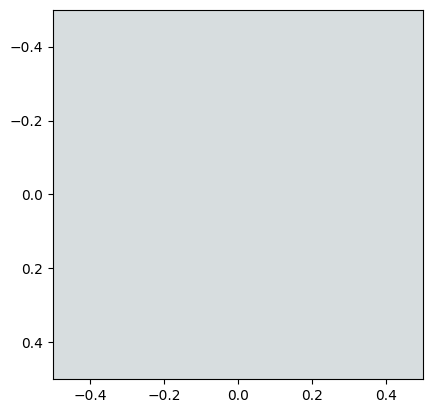

In [51]:
####### DETERMINATION DE LA COULEUR PREDOMINANTE SUR 1 IMAGE #######
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger l'image
img = cv2.imread('../../data/projet/import/images/8.jpg')

# Convertir l'image en matrice de pixels
pixels = np.float32(img.reshape(-1, 3))
print(pixels)
# Appliquer K-means avec 2 clusters
kmeans = KMeans(n_clusters=2, n_init=10).fit(pixels)
print("kmeans :",kmeans)
# Obtenir les centroids des clusters
centroids = kmeans.cluster_centers_
print("Centroids :",centroids)
# Déterminer la couleur prédominante
predominant_color = np.uint8(centroids[0])
print("Couleur prédominante :",predominant_color)
# Afficher la couleur prédominante sur l'image
plt.imshow([[(predominant_color / 255)]])
plt.show()


In [3]:
####### DETERMINATION DE LA COULEUR PREDOMINANTE SUR TOUTES LES IMAGES #######
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

images = os.listdir("../../data/projet/import/images")
images.pop(images.index(".ipynb_checkpoints"))
print(images)
# Charger les images

for image in images:
    # Charger l'image
    path = "../../data/projet/import/images/" + image

    img = cv2.imread(path)

    # Convertir l'image en matrice de pixels
    pixels = np.float32(img.reshape(-1, 3))

    # Appliquer K-means avec 2 clusters
    kmeans = KMeans(n_clusters=2,n_init=10).fit(pixels)

    # Obtenir les centroids des clusters
    centroids = kmeans.cluster_centers_

    # Déterminer la couleur prédominante
    predominant_color = np.uint8(centroids[0])
    print("Couleur prédominante :",image,predominant_color)
    # Afficher la couleur prédominante sur l'image
    #plt.imshow([[(predominant_color / 255)]])
    #plt.show()

['3.jpg', '40.jpg', '34.jpg', '21.jpg', '38.jpg', '1.jpg', '45.jpg', '66.jpg', '16.jpg', '29.jpg', '42.jpg', '37.jpg', '19.jpg', '73.jpg', '39.jpg', '75.jpg', '63.jpg', '12.jpg', '25.jpg', '56.jpg', '24.jpg', '13.jpg', '69.jpg', '60.jpg', '7.jpg', '70.jpg', '31.jpg', '26.jpg', '22.jpg', '11.jpg', '61.jpg', '46.jpg', '74.jpg', '58.jpg', '6.jpg', '53.jpg', '67.jpg', '43.jpg', '76.jpg', '15.jpg', '8.jpg', '47.jpg', '50.jpg', '71.jpg', '54.jpg', '59.jpg', '35.jpg', '62.jpg', '49.jpg', '41.jpg', '33.jpg', '64.jpg', '23.jpg', '20.jpg', '32.jpg', '10.jpg', '55.jpg', '27.jpg', '48.jpg', '72.jpg', '0.jpg', '36.jpg', '51.jpg', '17.jpg', '57.jpg', '68.jpg', '44.jpg', '9.jpg', '28.jpg', '14.jpg', '18.jpg', '4.jpg', '2.jpg', '52.jpg', '5.jpg', '30.jpg', '65.jpg']
Couleur prédominante : 3.jpg [81 53 37]
Couleur prédominante : 40.jpg [213 231 240]
Couleur prédominante : 34.jpg [175 175 175]
Couleur prédominante : 21.jpg [216 221 221]
Couleur prédominante : 38.jpg [ 73  90 105]
Couleur prédominante : 

In [57]:
####### CLUSTERING DES IMAGES EN FONCTION DE LA COULEUR PREDOMINANTE #######

import numpy as np
import cv2
from sklearn.cluster import KMeans

# Charger les images
images = ['../../data/projet/import/images/1.jpg', '../../data/projet/import/images/2.jpg', '../../data/projet/import/images/3.jpg']

# Créer une liste pour stocker les couleurs prédominantes de chaque image
predominant_colors = []

for image in images:
    # Charger l'image
    img = cv2.imread(image)

    # Convertir l'image en matrice de pixels
    pixels = np.float32(img.reshape(-1, 3))

    # Appliquer K-means avec 2 clusters
    kmeans = KMeans(n_clusters=2,n_init=10).fit(pixels)

    # Obtenir les centroids des clusters
    centroids = kmeans.cluster_centers_

    # Déterminer la couleur prédominante
    predominant_color = np.uint8(centroids[0])

    # Ajouter la couleur prédominante à la liste
    predominant_colors.append(predominant_color)

# Convertir la liste en tableau numpy
predominant_colors = np.array(predominant_colors)

# Appliquer K-means avec 2 clusters sur les couleurs prédominantes
kmeans = KMeans(n_clusters=2).fit(predominant_colors)

# Obtenir les labels de cluster pour chaque couleur prédominante
cluster_labels = kmeans.labels_

# Imprimer les labels de cluster pour chaque image
for i, image in enumerate(images):
    print("L'image {} appartient au cluster {}".format(image, cluster_labels[i]))

/home/pierre/Bureau/CPE LYON/S8/datamining/MachineLearning/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/pierre/Bureau/CPE LYON/S8/datamining/MachineLearning/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/pierre/Bureau/CPE LYON/S8/datamining/MachineLearning/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


L'image ../../data/projet/import/images/1.jpg appartient au cluster 0
L'image ../../data/projet/import/images/2.jpg appartient au cluster 1
L'image ../../data/projet/import/images/3.jpg appartient au cluster 1


/home/pierre/Bureau/CPE LYON/S8/datamining/MachineLearning/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
